In [1]:
import cv2
import numpy as np


def draw_circle(event,x,y,flags,param):
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(img,(x,y),10,(0,255,0),-1)
    elif event == cv2.EVENT_RBUTTONDOWN:    # マウスの右クリックのイベント
        cv2.circle(img,(x,y),100,(0,0,255),-1)

img = np.zeros((600,600,3), np.uint8)

cv2.namedWindow(winname='mouse_drawing')

cv2.setMouseCallback('mouse_drawing',draw_circle)

while True:
    cv2.imshow('mouse_drawing',img)
    if cv2.waitKey(20) & 0xFF == 27:
        break

cv2.destroyAllWindows()

In [1]:

import cv2
import numpy as np


drawing = False
ix,iy = -1,-1

def draw_rectangle(event,x,y,flags,param):
    global ix,iy,drawing

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        ix,iy = x,y

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing == True:
            cv2.rectangle(img,(ix,iy),(x,y),(0,255,0),-1)

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        # cv2.rectangle(img,(ix,iy),(x,y),(0,255,0),-1)

img = np.zeros((600,600,3))

cv2.namedWindow(winname='my_drawing')

cv2.setMouseCallback('my_drawing',draw_rectangle)

while True: 
    cv2.imshow('my_drawing',img)
    if cv2.waitKey(1) & 0xFF == 27:
        break

cv2.destroyAllWindows()

<IPython.core.display.Javascript object>


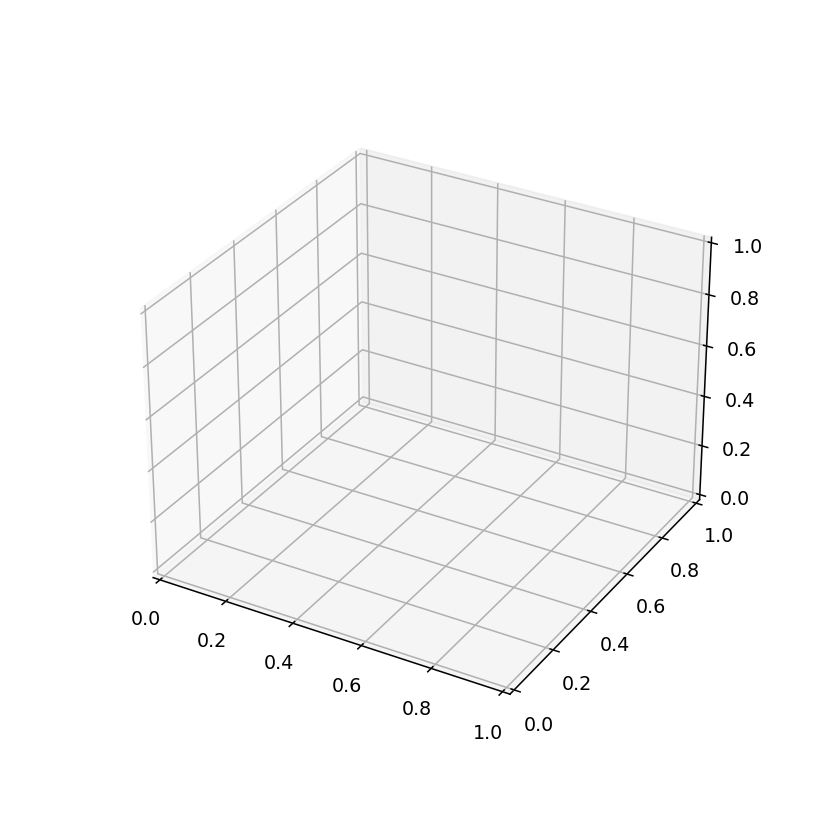

In [14]:
import cv2
import numpy as np
import time
import math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

%matplotlib notebook

drawing = False
ix,iy = -1,-1
color = 0
drawn_lines = np.empty(shape=[0, 5])
spatial_lines = np.empty(shape=[0, 6]) #elements are two end points
origin = [0, 0]
v_mat = np.empty(shape=[4, 4])

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})

In [1]:
import cv2
import numpy as np


def draw_circle(event,x,y,flags,param):
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(img,(x,y),10,(0,255,0),-1)
    elif event == cv2.EVENT_RBUTTONDOWN:    # マウスの右クリックのイベント
        cv2.circle(img,(x,y),100,(0,0,255),-1)

img = np.zeros((600,600,3), np.uint8)

cv2.namedWindow(winname='mouse_drawing')

cv2.setMouseCallback('mouse_drawing',draw_circle)

while True:
    cv2.imshow('mouse_drawing',img)
    if cv2.waitKey(20) & 0xFF == 27:
        break

cv2.destroyAllWindows()

In [120]:
import cv2
import numpy as np


drawing = False
ix,iy = -1,-1

def draw_rectangle(event,x,y,flags,param):
    global ix,iy,drawing

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        ix,iy = x,y

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing == True:
            cv2.rectangle(img,(ix,iy),(x,y),(0,255,0),-1)

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        # cv2.rectangle(img,(ix,iy),(x,y),(0,255,0),-1)

img = np.zeros((600,600,3))

cv2.namedWindow(winname='my_drawing')

cv2.setMouseCallback('my_drawing',draw_rectangle)

while True: 
    cv2.imshow('my_drawing',img)
    if cv2.waitKey(1) & 0xFF == 27:
        break

cv2.destroyAllWindows()

In [ ]:
import cv2
import numpy as np
import time
import math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

%matplotlib notebook

drawing = False
ix,iy = -1,-1
color = 0
drawn_lines = np.empty(shape=[0, 5])
spatial_lines = np.empty(shape=[0, 6]) #elements are two end points
origin = [0, 0]
v_mat = np.empty(shape=[4, 4])
mean_h3d = 0.
mean_h2d = 0.

def gauss_func(x, sigma):
     return (1 / math.sqrt(2 * math.pi * (sigma ** 2))) * math.exp(-(x - 0) ** 2 / (2 * (sigma ** 2)))

def vector_cos(a, b):
    ax1, ay1, ax2, ay2, _ = a
    bx1, by1, bx2, by2, _ = b
    ax = ax2 - ax1
    ay = ay2 - ay1
    bx = bx2 - bx1
    by = by2 - by1
    d = ax * bx + ay * by
    r = math.sqrt((ax * ax + ay * ay) * (bx * bx + by * by))
    return d / r

def camera_direction(xline, yline, zline): 
    c1 = vector_cos(xline, yline)
    c2 = vector_cos(yline, zline)
    c3 = vector_cos(zline, xline)
    c12 = c1 * c2
    c23 = c2 * c3
    c31 = c3 * c1
    return [-math.sqrt(c31 / (c31 - c2)), -math.sqrt(c12 / (c12 - c3)), -math.sqrt(c23 / (c23 - c1))]

def detect_intersections(l, ls): #2D intersections
    intersections = np.empty(shape=[0, 3])
    ax, ay, bx, by, _ = l
    for i in range(len(ls)):
        cx, cy, dx, dy, _ = ls[i]
        acx = cx - ax
        acy = cy - ay
        bunbo = (bx - ax)*(dy - cy) - (by - ay)*(dx - cx)
        if (bunbo != 0):
            r = ((dy - cy)*acx - (dx - cx)*acy) / bunbo
            s = ((by - ay)*acx - (bx - ax)*acy) / bunbo
            if (0 <= r and r <= 1 and 0 <= s and s <= 1):
                intersection = [(1 - r) * ax + r * bx, (1 - r) * ay + r * by, i]
                #print(intersection)
                intersections = np.append(intersections, [intersection], axis=0)
    return intersections

def view_matrix(dirc, yline, origin):
    sx, sy, tx, ty, _ = yline
    dist = 3000 #between the origin and the camera
    dx, dy, dz = dirc
    m1 = np.zeros((4, 4)) 
    rx = math.sqrt(dy * dy + dz * dz)
    ry = math.sqrt(1 - dx * dx)
    #neg_y = np.array([[1,0,0,0],[0,-1,0,0],[0,0,1,0],[0,0,0,1]])
    m1[0][0:3] = [0, -dz/rx, dy/rx]
    m1[1][0:3] = [(1 - dx * dx)/ry, - dx * dy/ry, -dx * dz/ry]
    m1[2][0:3] = dirc
    m1[3][0:4] = [0,0,0,1] #[dx*dist, dy*dist, dz*dist, 1]
    #print((-dz/rx) * (-dx*dy/ry) + (dy/rx) * (-dx)*dz/ry)
    #print((-dz/rx) * dirc[1] + (dy/rx) * dirc[2])
    
    #print(m1)
    #v1 = np.linalg.inv(m1) 
    #print(v1)
    #print((m1).dot([[1], [0], [0], [1]]))
    #print((m1).dot([[0], [1], [0], [1]]))
    #print((m1).dot([[0], [0], [1], [1]]))
    t1 = np.array([[1, 0, 0, origin[0]], 
                   [0, 1, 0, origin[1]], 
                   [0, 0, 1, 0], 
                   [1, 1, 1, 1]]) #trans
    #print(t1)
    pre_yline = ((m1).dot([[0], [1], [0], [1]]).reshape([1, -1]))
    pre_yline_argument = math.atan2(pre_yline[0,1], pre_yline[0,0])
    yline_argument = math.atan2((ty - sy), (tx - sx))
    #print(pre_yline_argument, yline_argument)
    phase = yline_argument - pre_yline_argument
    r1 = np.array([[math.cos(phase), -math.sin(phase), 0, 0],
                  [math.sin(phase), math.cos(phase), 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]]) #rotate
    return t1.dot(r1).dot(m1)

def camera_matrix(view_mat):
    return np.linalg.inv(view_mat) 

def make_x_axis_aligned_line(line, spatial_points, v_mat):
    xline_ix, _, xline_x, _, _ = line #|xline_ix - x;ine_x| > 1にしたほうがよさそう
    unit_10x = np.array([10, 0, 0, 1]) + np.concatenate([(spatial_points), np.array([0])])
    unit_20x = np.array([20, 0, 0, 1]) + np.concatenate([(spatial_points), np.array([0])])
    im_unit_10x = v_mat[0].dot(unit_10x)
    im_unit_20x = v_mat[0].dot(unit_20x)
    bunbo = im_unit_10x - im_unit_20x
    s = (xline_ix - im_unit_20x) / bunbo
    t = (xline_x - im_unit_20x) / bunbo
    return [(unit_10x * s + unit_20x * (1 - s))[0:3], (unit_10x * t + unit_20x * (1 - t))[0:3]]

def make_y_axis_aligned_line(line, spatial_points, v_mat):
    yline_ix, _, yline_x, _, _ = line
    unit_10y = np.array([0, 10, 0, 1]) + np.concatenate([(spatial_points), np.array([0])])
    unit_20y = np.array([0, 20, 0, 1]) + np.concatenate([(spatial_points), np.array([0])])
    im_unit_10y = v_mat[0].dot(unit_10y)
    im_unit_20y = v_mat[0].dot(unit_20y)
    bunbo = im_unit_10y - im_unit_20y
    s = (yline_ix - im_unit_20y) / bunbo
    t = (yline_x - im_unit_20y) / bunbo
    return [(unit_10y * s + unit_20y * (1 - s))[0:3], (unit_10y * t + unit_20y * (1 - t))[0:3]]

def make_z_axis_aligned_line(line, spatial_points, v_mat):
    zline_ix, _, zline_x, _, _ = line
    unit_10z = np.array([0, 0, 10, 1]) + np.concatenate([(spatial_points), np.array([0])])
    unit_20z = np.array([0, 0, 20, 1]) + np.concatenate([(spatial_points), np.array([0])])
    im_unit_10z = v_mat[0].dot(unit_10z)
    im_unit_20z = v_mat[0].dot(unit_20z)
    bunbo = im_unit_10z - im_unit_20z
    s = (zline_ix - im_unit_20z) / bunbo
    t = (zline_x - im_unit_20z) / bunbo
    return [(unit_10z * s + unit_20z * (1 - s))[0:3], (unit_10z * t + unit_20z * (1 - t))[0:3]]

def init_3d_lines(v_mat, ls):
    line0 = make_x_axis_aligned_line(ls[0], np.array([0,0,0]), v_mat)
    line1 = make_y_axis_aligned_line(ls[1], np.array([0,0,0]), v_mat)
    line2 = make_z_axis_aligned_line(ls[2], np.array([0,0,0]), v_mat)
    
    return [line0, line1, line2]

def length_2d(d_line):
    ix, iy, x, y, _ = d_line
    return math.sqrt((ix - iy) ** 2 + (x - y) ** 2)

def length_3d(s_line):
    #print(s_line)
    dir = s_line[0] - s_line[1]
    return math.sqrt(sum(dir ** 2))

def init_means(s_lines, d_lines):
    l3x = math.sqrt(sum((s_lines[0][0] - s_lines[0][1])**2))
    l3y = math.sqrt(sum((s_lines[1][0] - s_lines[1][1])**2))
    l3z = math.sqrt(sum((s_lines[2][0] - s_lines[2][1])**2))
    return [(l3x + l3y + l3z) / 3, (length_2d(d_lines[0]) + length_2d(d_lines[1]) + length_2d(d_lines[2])) / 3]

def find_spatial_point(sp_line, dr_line, point):
    px, py = point
    dix, diy, dx, dy, _ = dr_line
    bunbo = dix - dx
    t = (px - dx) / bunbo
    s_iv, s_v = sp_line
    return (s_iv * t + s_v * (1 - t))[0:3]

def make_through_two_points(v_mat, point1, point2, line):#3D交点と2D線分から、3D線分を計算
    ix, _, x, _, _ = line
    #print(point1)
    point_vector1 = np.concatenate([point1, np.array([1])])
    point_vector2 = np.concatenate([point2, np.array([1])])
    drawn_intersection1 = v_mat[0].dot(point_vector1)
    drawn_intersection2 = v_mat[0].dot(point_vector2)
    bunbo = drawn_intersection1 - drawn_intersection2
    s = (ix - drawn_intersection2) / bunbo
    t = (x - drawn_intersection2) / bunbo
    return [point1 * s + point2 * (1 - s), point1 * t + point2 * (1 - t)]

def q_coverage(line, intersection1, intersection2):
    ix, iy, x, y, _ = line
    ox1, oy1, _ = intersection1
    ox2, oy2, _ = intersection2
    segment = abs(ox1 - ox2) + abs(oy1 - oy2)
    length = abs(x - ix) + abs(y - iy)
    return segment / length

def q_axis(unit, candidate_line):
    sigma = 0.01135
    c1, c2 = candidate_line
    direction = c1 - c2
    length = np.sqrt(sum(direction**2))
    #print (abs(unit.dot(direction)) / length, gauss_func(0, sigma))
    return (gauss_func(1 - (abs(unit.dot(direction)) / length), sigma)) / gauss_func(0, sigma)

def q_ortho(candidate_line, ad_line):
    sigma = 0.086
    c1, c2 = candidate_line
    c_direction = c1 - c2
    c_length = np.sqrt(sum(c_direction**2))
    a1, a2 = ad_line
    a_direction = a1 - a2
    a_length = np.sqrt(sum(a_direction**2))
    #print(c_direction, a_direction)
    #print(abs(c_direction.dot(a_direction)) / (c_length * a_length))
    return gauss_func(abs(c_direction.dot(a_direction)) / (c_length * a_length), sigma) / gauss_func(0, sigma)

def q_planar(candidate_line, ad_line1, ad_line2):
    sigma = 0.086
    c1, c2 = candidate_line
    c_direction = c1 - c2
    c_length = np.sqrt(sum(c_direction**2))
    c_direction = c_direction / c_length
    a1, a2 = ad_line1
    a_direction = a1 - a2
    b1, b2 = ad_line2
    b_direction = b1 - b2
    n = np.array([a_direction[1] * b_direction[2] - a_direction[2] * b_direction[1],
                 a_direction[2] * b_direction[0] - a_direction[0] * b_direction[2],
                 a_direction[0] * b_direction[1] - a_direction[1] * b_direction[0]])
    n_length = np.sqrt(sum(n**2))
    n = n / n_length
    #print(abs(c_direction.dot(n)))
    return gauss_func(abs(c_direction.dot(n)), sigma) / gauss_func(0, sigma)

def q_tangent(candidate_line, ad_line):
    sigma = 0.086
    c1, c2 = candidate_line
    c_direction = c1 - c2
    c_length = np.sqrt(sum(c_direction**2))
    a1, a2 = ad_line
    a_direction = a1 - a2
    a_length = np.sqrt(sum(a_direction**2))
    #print(c_direction, a_direction)
    #print(abs(c_direction.dot(a_direction)) / (c_length * a_length))
    return gauss_func(1 - abs(c_direction.dot(a_direction)) / (c_length * a_length), sigma) / gauss_func(0, sigma)


def draw_true_intersections(intersection_id, intersections):
    for i in range(len(intersection_id)):
        px, py, _ = intersections[intersection_id[i]]
        cv2.circle(img,(int(px), int(py)), 3, (0, 1, 1), -1)
        
def distance_point_line(point, line):
    a, b, c = line[0]
    d, e, f = line[1]
    p, q, r = point
    da = d - a
    eb = e - b
    fc = f - c
    pa = p - a
    qb = q - b
    rc = r - c
    t = (da * pa + eb * qb + fc * rc) / (da * da + eb * eb + fc * fc)
    if (t > 1.1):
        return 1000
    else:
        n = np.array([da * t - pa, eb * t - qb, fc * t - rc])
        return math.sqrt(n.dot(n))

def detect_line_near_point(sp_lines, point):
    index_list = []
    for i in range(len(sp_lines)):
        line = sp_lines[i]
        d = distance_point_line(point, line)
        if (d < 10):
            index_list = index_list + [i]
    return index_list

def accept(max_value, second_max_value):
    t_scorehigh = 0.98
    t_score = 0.75
    t_ambiguity = 0.8
    return (max_value > t_scorehigh) or ((max_value > t_score) and second_max_value / max_value < t_ambiguity)
def draw_line(event,x,y,flags,param): #lineを引かれる度に計算
    global ix,iy,drawing, color, drawn_lines, spatial_lines, origin, v_mat, mean_h3d, mean_h2d

    if event == cv2.EVENT_LBUTTONDOWN:
        ix,iy = x,y
        #cv2.circle(img,(ix, iy), 3, (1, 1, 1), -1)
        drawing = True
    elif (event == cv2.EVENT_LBUTTONUP):
        drawing = False
        if color == 1:
            cv2.line(img,(ix,iy),(x,y),(0,0,1))
        elif color == 2:
            cv2.line(img,(ix,iy),(x,y),(0,1,0))
        elif color == 3:
            cv2.line(img,(ix,iy),(x,y),(1,0,0))
        else :
            cv2.line(img,(ix,iy),(x,y),(1,1,1))
            
        new_line = [ix, iy, x, y, color]
        #print(new_line)
        #print(new_line[2]-new_line[0], new_line[3]-new_line[1])
        intersections = detect_intersections(new_line, drawn_lines)
        drawn_lines = np.append(drawn_lines, [new_line], axis=0)
        for i in range(len(intersections)):
            px, py, _ = intersections[i]
            cv2.circle(img,(int(px), int(py)), 3, (255,255,255), -1)
        #print(intersections)
        
        if (len(drawn_lines) == 2):
            ox, oy, _ = intersections[0]
            origin = [ox, oy]
            #print(origin)
        
        elif (len(drawn_lines) == 3):
            cam_dirc = camera_direction(drawn_lines[0], drawn_lines[1], drawn_lines[2]) #the direction of the camera
            #print(cam_dirc)
            v_mat = view_matrix(cam_dirc, drawn_lines[1], origin)
            c_mat = camera_matrix(v_mat)
            spatial_lines = init_3d_lines(v_mat, drawn_lines)
            mean_h3d, mean_h2d = init_means(spatial_lines, drawn_lines)
            print(mean_h3d, mean_h2d)
            #print(spatial_lines)
        
        elif (len(intersections) == 1 and color != 0):
            ox, oy, p_index = intersections[0]
            spartial_partner_line = spatial_lines[int(p_index)]
            drawn_partner_line = drawn_lines[int(p_index)]
            
            spatial_point = find_spatial_point(spartial_partner_line, drawn_partner_line, [ox, oy])
            #print(spatial_point)
            
            if (color == 1):
                spatial_lines = np.append(spatial_lines, [make_x_axis_aligned_line(new_line, spatial_point, v_mat)], axis=0)
            elif (color == 2):
                spatial_lines = np.append(spatial_lines, [make_y_axis_aligned_line(new_line, spatial_point, v_mat)], axis=0)
            elif (color == 3):
                spatial_lines = np.append(spatial_lines, [make_z_axis_aligned_line(new_line, spatial_point, v_mat)], axis=0)
                
            draw_true_intersections([0], intersections)
            #print(spatial_lines)
        elif (len(drawn_lines) >= 4):
            candidate_lines = [] # np.empty(shape = [0,2,3])
            intersection_id = [] #3Dintersectionに対応する2Dintersection
            #second_intersection_id = []
            max_value = 0
            best_candidate_line = []
            second_max_value = 0
            second_best_candidate_line = []
            q_a = 0
            q_p = 0
            q_o = 0
            q_t = 0
            q = 0
            
            #####additional_candidate_line#####
            if (color > 0):
                for i in range(len(intersections)):
                    ox, oy, p_index = intersections[i]
                    spartial_partner_line = spatial_lines[int(p_index)]
                    drawn_partner_line = drawn_lines[int(p_index)]
                    spatial_point = find_spatial_point(spartial_partner_line, drawn_partner_line, [ox, oy])
                    if (color == 1):
                        candidate_line = make_x_axis_aligned_line(new_line, spatial_point, v_mat)
                        q_a = q_axis(np.array([1,0,0]), candidate_line)
                        #candidate_lines = np.append(candidate_lines, [make_x_axis_aligned_line(new_line, spatial_point, v_mat)], axis=0)
                    elif (color == 2):
                        candidate_line = make_y_axis_aligned_line(new_line, spatial_point, v_mat)
                        q_a = q_axis(np.array([0,1,0]), candidate_line)
                        #candidate_lines = np.append(candidate_lines, [make_y_axis_aligned_line(new_line, spatial_point, v_mat)], axis=0)
                    elif (color == 3):
                        candidate_line = make_z_axis_aligned_line(new_line, spatial_point, v_mat)
                        q_a = q_axis(np.array([0,0,1]), candidate_line)
                        #candidate_lines = np.append(candidate_lines, [make_z_axis_aligned_line(new_line, spatial_point, v_mat)], axis=0)
                    q = 0.4 * q_a
                    candidate_lines = candidate_lines +  [[candidate_line, q]]#np.append(candidate_lines, [candidate_line], axis=0)
                    if (q > max_value):
                        max_value = q
                        intersection_id = [i]
                        best_candidate_line = candidate_line
                    
            ######この段階で評価######
            #max_value q = 0.4 * q_a
            #intersection_id = [0]
            #best_candidate_line = candidate_line
                    
            for i in range(0, len(intersections) - 1):
                ox1, oy1, p_index1 = intersections[i]
                spartial_partner_line1 = spatial_lines[int(p_index1)]
                drawn_partner_line1 = drawn_lines[int(p_index1)]
                spatial_point1 = find_spatial_point(spartial_partner_line1, drawn_partner_line1, [ox1, oy1])
                for j in range(i + 1, len(intersections)):
                    ox2, oy2, p_index2 = intersections[j]
                    spartial_partner_line2 = spatial_lines[int(p_index2)]
                    drawn_partner_line2 = drawn_lines[int(p_index2)]
                    spatial_point2 = find_spatial_point(spartial_partner_line2, drawn_partner_line2, [ox2, oy2])
                    candidate_line = make_through_two_points(v_mat, spatial_point1, spatial_point2, new_line)
                    if (length_3d(candidate_line) / mean_h3d > length_2d(new_line) * 3 / mean_h2d 
                        and len(intersections) > 2 and (not(max_value == 0 and i+j == len(intersections) * 2 - 3))):
                        print("skip")
                        continue
                    q_c = q_coverage(new_line, intersections[i], intersections[j])
                    q_a = 0
                    q_p = 0
                    q_o = 0
                    q_t = 0
                    #print(q_c)
                    if (color == 1):
                        q_a = q_axis(np.array([1,0,0]), candidate_line)
                    elif (color == 2):
                        q_a = q_axis(np.array([0,1,0]), candidate_line)
                    elif (color == 3):
                        q_a = q_axis(np.array([0,0,1]), candidate_line)
                    #print(q_a)
                    else:
                        index_list1 = detect_line_near_point(spatial_lines, spatial_point1)
                        index_list2 = detect_line_near_point(spatial_lines, spatial_point2)
                        #print(index_list1)
                        for i0 in range(len(index_list1)):
                            q_o = max(q_ortho(candidate_line, spatial_lines[index_list1[i0]]), q_o)
                            q_t = max(q_tangent(candidate_line, spatial_lines[index_list1[i0]]), q_t)
                        for i1 in range(len(index_list2)):
                            q_o = max(q_ortho(candidate_line, spatial_lines[index_list2[i1]]), q_o)
                            q_t = max(q_tangent(candidate_line, spatial_lines[index_list2[i1]]), q_t)
                                
                        if (len(index_list1) >= 2):
                            #print(index_list1)
                            for i2 in range(0, len(index_list1) - 1):
                                for j2 in range(i2 + 1, len(index_list1)):
                                    #print(i, j, index_list1[i2], index_list1[j2])
                                    q_p = max(q_planar(candidate_line, spatial_lines[index_list1[i2]], spatial_lines[index_list1[j2]]), q_p)
                                    #print(q_p)
                        if (len(index_list2) >= 2):
                            #print(index_list2)
                            for i2 in range(0, len(index_list2) - 1):
                                for j2 in range(i2 + 1, len(index_list2)):
                                    #print(i, j, index_list2[i2], index_list2[j2])
                                    q_p = max(q_planar(candidate_line, spatial_lines[index_list2[i2]], spatial_lines[index_list2[j2]]), q_p)
                        #print(q_a)
                        #print(detect_line_near_point(spatial_lines, spatial_point1), 
                        #      detect_line_near_point(spatial_lines, spatial_point2))
                        
                    print(q_a, q_o, q_p, q_t)
                    q_g = max(q_a, q_o, q_p, q_t)
                    q = 0.4 * q_c + 0.4 * q_g + 0.2 * q_c * q_g
                    #print(i, j, q_c, q_a, q)
                    candidate_lines = candidate_lines +  [[candidate_line, q]]
                    if (q > max_value):
                        second_max_value = max_value
                        max_value = q
                        intersection_id = [i,j]
                        second_best_candidate_line = best_candidate_line
                        best_candidate_line = candidate_line
            print(intersection_id, max_value, second_max_value)
            if (accept(max_value, second_max_value)):
                print("accept")
                spatial_lines = np.append(spatial_lines, [best_candidate_line], axis=0)
                mean_h3d = ((len(drawn_lines) - 1) * mean_h3d + length_3d(best_candidate_line)) / len(drawn_lines)
                mean_h2d = ((len(drawn_lines) - 1) * mean_h2d + length_2d(new_line)) / len(drawn_lines)
            else:
                print("not accept")
                spatial_lines = np.append(spatial_lines, [best_candidate_line], axis=0)
                mean_h3d = ((len(drawn_lines) - 1) * mean_h3d + length_3d(best_candidate_line)) / len(drawn_lines)
                mean_h2d = ((len(drawn_lines) - 1) * mean_h2d + length_2d(new_line)) / len(drawn_lines)
            #print(detect_line_near_point(spatial_lines, spatial_point2))
            print(best_candidate_line)
            #mean_h3d = ((len(drawn_lines) - 1) * mean_h3d + length_3d(best_candidate_line)) / len(drawn_lines)
            #mean_h2d = ((len(drawn_lines) - 1) * mean_h2d + length_2d(new_line)) / len(drawn_lines)
            print(mean_h3d, mean_h2d)
            #spatial_lines = np.append(spatial_lines, [best_candidate_line], axis=0)
            print(candidate_lines)
            draw_true_intersections(intersection_id, intersections)
    
    while drawing:
        key = cv2.waitKey(500) & 0xFF
        if  key == ord('x'):
            color = 1
        elif key == ord('y'):
            color = 2
        elif key == ord('z'):
            color = 3
        else:
            color = 0
    
img = np.zeros((800,1000,3))

cv2.namedWindow(winname='my_drawing')

cv2.setMouseCallback('my_drawing',draw_line)

#cv2.imshow('my_drawing',img)
#cv2.waitKey()


while True: 
    cv2.imshow('my_drawing',img)
    #fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
    #if (len(X) < len(spatial_lines) * 2):
        #for i in range(len(spatial_lines)):
            #X = X + [spatial_lines[i][0][0]] + [spatial_lines[i][1][0]]
            #Y = Y + [spatial_lines[i][0][1]] + [spatial_lines[i][1][1]]
            #Z = Z + [spatial_lines[i][0][2]] + [spatial_lines[i][1][2]]
        #ax.plot(X, Y, Z,marker="o",linestyle='None')
        #plt.draw()
        #plt.pause(sleepTime)
        #plt.cla()
    if (cv2.waitKey(1) & 0xFF == 27):
        break

cv2.destroyAllWindows()


fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
#X = []
#Y = []
#Z = []
xmax = 0
xmin = 0
ymax = 0
ymin = 0
zmax = 0
zmin = 0

for i in range(len(spatial_lines)):
    x0 = spatial_lines[i][0][0]
    x1 = spatial_lines[i][1][0]
    y0 = spatial_lines[i][0][1]
    y1 = spatial_lines[i][1][1]
    z0 = spatial_lines[i][0][2]
    z1 = spatial_lines[i][1][2]
    X = [x0, x1]
    Y = [y0, y1]
    Z = [z0, z1]
    xmax = max(xmax, x0, x1)
    ymax = max(ymax, y0, y1)
    zmax = max(zmax, z0, z1)
    xmin = min(xmin, x0, x1)
    ymin = min(ymin, y0, y1)
    zmin = min(zmin, z0, z1)
    ax.plot(X, Y, Z, ".-", color="#00aa00", ms=4, mew=0.5)
    
max_range = np.array([xmax - xmin, ymax - ymin, zmax - zmin]).max() * 0.5

mid_x = (xmax + xmin) * 0.5
mid_y = (ymax + ymin) * 0.5
mid_z = (zmax + zmin) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
plt.show()

343.6008677088933 253.52912808679466
1.431765438918901e-15 0 0 0
[0] 0.4 0
not accept
[array([280.18473038,   0.        , 247.12233104]), array([-47.4097213 ,   0.        , 247.12233104])]
340.39958450411183 251.14555407260505
[[[array([280.18473038,   0.        , 247.12233104]), array([-47.4097213 ,   0.        , 247.12233104])], 0.4], [[array([307.28483452,   0.        , 110.41002971]), array([-20.30961717,   0.        , 110.41002971])], 0.4], [[array([308.75039529,   0.        , 103.01669329]), array([-52.24328311,   0.        , 271.50627271])], 0.32455965953274973]]
